# K-NN Classifier - Personal Loan Acceptance

This program is a solution to the problem 7.2 of chapter 7 of following book. 

Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python, First Edition.

Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel

© 2020 John Wiley & Sons, Inc. Published 2020 by John Wiley & Sons, Inc.

## Importing Libraries

In [266]:
import numpy as np
import pandas as pd

import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt

Printing versions of libraries

In [267]:
print('numpy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('sklearn version: {}'.format(skl.__version__))
print('matplotlib version: {}'.format(mpl.__version__))

numpy version: 1.23.5
pandas version: 1.5.3
sklearn version: 1.2.1
matplotlib version: 3.7.0


## Loading Dataset

In [268]:
df = pd.read_csv('UniversalBank.csv')

In [269]:
df.shape

(5000, 14)

In [270]:
# Renaming columns to remove space in column names
df = df.rename(columns={'ZIP Code': 'ZIP_Code', 
                        'Personal Loan': 'Personal_Loan', 
                        'Securities Account': 'Securities_Account', 
                        'CD Account':'CD_Account'})

# Dropping columns ID and ZIP Code because they are not needed for our k-nn classification.
df = df.drop(['ID', 'ZIP_Code'], axis=1)
display(df.head())

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


In [271]:
display(df.head())

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


Transforming categorical predictors with more than two categories into dummy variables first

In [272]:
# Create dummy variables from the Education column
df = pd.get_dummies(df, columns=['Education'])
display(df.head())

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3
0,25,1,49,4,1.6,0,0,1,0,0,0,1,0,0
1,45,19,34,3,1.5,0,0,1,0,0,0,1,0,0
2,39,15,11,1,1.0,0,0,0,0,0,0,1,0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,0,1,0
4,35,8,45,4,1.0,0,0,0,0,0,1,0,1,0


Making Personal_Loan as a last column of the dataframe.

In [273]:
column_to_move = df.pop('Personal_Loan')
df.insert((len(list(df))), 'Personal_Loan', column_to_move)
display(df.head())

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3,Personal_Loan
0,25,1,49,4,1.6,0,1,0,0,0,1,0,0,0
1,45,19,34,3,1.5,0,1,0,0,0,1,0,0,0
2,39,15,11,1,1.0,0,0,0,0,0,1,0,0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,1,0,0
4,35,8,45,4,1.0,0,0,0,0,1,0,1,0,0


Partitioning the data into training (60%) and validation (40%) sets.

In [274]:
trainData, validData = train_test_split(df, 
                                        test_size=0.4, 
                                        random_state=26)

Creating dataset for prospect customer

In [275]:
prospect = pd.DataFrame([{'Age': 40, 
                          'Experience': 10, 
                          'Income': 84, 
                          'Family': 2, 
                          'CCAvg': 2, 
                          'Mortgage': 0, 
                          'Securities_Account': 0, 
                          'CD_Account': 0, 
                          'Online': 1, 
                          'CreditCard': 1, 
                          'Education_1': 0, 
                          'Education_2': 1, 
                          'Education_3': 0}])
display(prospect)

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3
0,40,10,84,2,2,0,0,0,1,1,0,1,0


## Normalizing Dataset

In [276]:
# initialize normalized training, validation, and complete data frames
# use the training data to learn the transformation.
scaler = preprocessing.StandardScaler()
scaler.fit(trainData.iloc[:, :-1]) 

# Transform the full dataaset 
dfNorm = pd.concat([pd.DataFrame(
    scaler.transform(df.iloc[:, :-1]), 
    columns= df.columns.tolist()[:-1]),
                       df[['Personal_Loan']]], axis=1)

display(dfNorm.head())

trainNorm = dfNorm.iloc[trainData.index]
validNorm = dfNorm.iloc[validData.index]

prospectNorm = pd.DataFrame(scaler.transform(prospect),
                                columns=prospect.columns)
display(prospectNorm)

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3,Personal_Loan
0,-1.761111,-1.655564,-0.525899,1.400063,-0.179980,-0.547625,2.888909,-0.248891,-1.24019,-0.645314,1.167135,-0.629800,-0.643242,0
1,-0.025599,-0.092619,-0.855538,0.529738,-0.237394,-0.547625,2.888909,-0.248891,-1.24019,-0.645314,1.167135,-0.629800,-0.643242,0
2,-0.546253,-0.439940,-1.360985,-1.210912,-0.524464,-0.547625,-0.346151,-0.248891,-1.24019,-0.645314,1.167135,-0.629800,-0.643242,0
3,-0.893355,-0.960922,0.594874,-1.210912,0.451575,-0.547625,-0.346151,-0.248891,-1.24019,-0.645314,-0.856799,1.587806,-0.643242,0
4,-0.893355,-1.047752,-0.613803,1.400063,-0.524464,-0.547625,-0.346151,-0.248891,-1.24019,1.549632,-0.856799,1.587806,-0.643242,0


,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3
0,-0.459477,-0.874091,0.243259,-0.340587,0.049677,-0.547625,-0.346151,-0.248891,0.806328,1.549632,-0.856799,1.587806,-0.643242


## K-NN Classification (K = 1)

Performing a k-NN classification with all predictors except ID and ZIP code using k = 1.

In [277]:
# use NearestNeighbors from scikit-learn to compute knn
knn = NearestNeighbors(n_neighbors=1)
knn.fit(dfNorm.iloc[:, :-1])
distances, indices = knn.kneighbors(prospectNorm)

# indices is a list of lists, we are only interested in the first element
dfNorm.iloc[indices[0], :]

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_1,Education_2,Education_3,Personal_Loan
4034,-0.893355,-0.787261,0.199307,-0.340587,-0.122566,-0.547625,-0.346151,-0.248891,0.806328,1.549632,-0.856799,1.587806,-0.643242,0


## Result

From above grid we see that closest neighbors to our prospect customer is a customer who did not accept the loan. Therefore, our prospect customer is also not likely to accept the loan. Since we are using only one neighbor, the cutoff value of 0.5 is not applicable here. However, as we will see further, the cutoff value will be applicable when we try classification with more than one neighbor.

## Finding best value of k 

Finding choice of k that balances between overfitting and ignoring the predictor information. Trying out k = 1 to k = 15. 

In [278]:
train_X = trainNorm.drop('Personal_Loan', axis=1)
train_y = trainNorm['Personal_Loan']
valid_X = validNorm.drop('Personal_Loan', axis=1)
valid_y = validNorm['Personal_Loan']

# Train a classifier for different values of k
results = []
for k in range(1, 16):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })
    
# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1    0.9550
1    2    0.9460
2    3    0.9555
3    4    0.9445
4    5    0.9525
5    6    0.9445
6    7    0.9495
7    8    0.9425
8    9    0.9460
9   10    0.9430
10  11    0.9450
11  12    0.9390
12  13    0.9405
13  14    0.9350
14  15    0.9380


## Result

From above table we see that accuracy is best when k = 3. Therefore, when we use k = 3, we will get the best classification performance. Choice of k = 3 will balance between overfitting and ignoring the predictor information. If we choose value of k that is less than 3, then we will classify in a way that is very sensitive to the local characteristics of the training data. Likewise, if we choose a very large value of k, such as k = 15, we sould simply predict the most frequent class in the dataset in all cases. K = 15 would be very stable prediction but it will completely ignore the information in the predictors.

## Confusion Matrix

Displaying the confusion matrix for the validation data that results from using the best k. In our case, it is k = 3.

In [279]:
knn = KNeighborsClassifier(n_neighbors=3).fit(train_X, train_y)
predicted = knn.predict(valid_X)

cm = confusion_matrix(valid_y, predicted)
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[1779    6]
 [  83  132]]


Defining method to find counts of Actual and Predicted values so that we can label the axes correctly while plotting confusion matrix.

In [280]:
def findOutputCounts(actual, predicted):   
    assert isinstance(actual, np.ndarray), "Argument 'actual' must be a numpy array."
    assert isinstance(predicted, np.ndarray), "Argument 'predicted' must be a numpy array."
    
    print('Actual Value Counts')
    print('Total Element Count: {}'.format(len(actual)))
    print('Not Accept Count: {}'.format(len(actual[actual == 0])))
    print('Accept Count: {}'.format(len(actual[actual == 1])))

    print('\nPredicted Value Counts')
    print('Total Element Count: {}'.format(len(predicted)))
    print('Not Accept Count: {}'.format(len(predicted[predicted == 0])))
    print('Accept Count: {}'.format(len(predicted[predicted == 1])))

In [281]:
findOutputCounts(valid_y.to_numpy(), predicted)

Actual Value Counts
Total Element Count: 2000
Not Accept Count: 1785
Accept Count: 215

Predicted Value Counts
Total Element Count: 2000
Not Accept Count: 1862
Accept Count: 138


Combining information from above confusion matrix and value counts we can conclude following about labels of axes in plot of confusion matrix. 

1. Sum of values in top row of confusion matrix above (1779 + 6) = 1785, which is Not Accept Count of Actual values as calculated above. Therefore, in the plot below, on the y-axis, where we display Acutal counts, the label of top row will be 'Not Accept'. If the label of top row is 'Not Accept' then label of bottom row will be 'Accept'.

2. Likewise, Sum values in the first column of confusion matrix above (1779 + 83) = 1862, which is Not Accept Count of Predicted values as calculated above. Therefore, the plot below, on the x-axis, where we display Predicted counts, the label of first column will be 'Not Accept'. If the label of first column is 'Not Accept', then the label of second column will be 'Accept'.

Defining method to plot confusion matrix

In [282]:
def PlotConfusionMatrix(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm)

    # Showing all ticks and labelling them with the respective list entries
    ax.set_xticks(np.arange(2), labels=['Not Accept', 'Accept'])
    ax.set_yticks(np.arange(2), labels=['Not Accept', 'Accept'])

    # Setting labels for x-axis and y-axis
    ax.set_xlabel('Predicted', fontsize=13)
    ax.set_ylabel('Actual', fontsize=13)

    # Creating text annotations.
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, cm[i, j], color='r')

    ax.set_title('Confusion Matrix', fontsize=15)
    fig.tight_layout()
    plt.show()

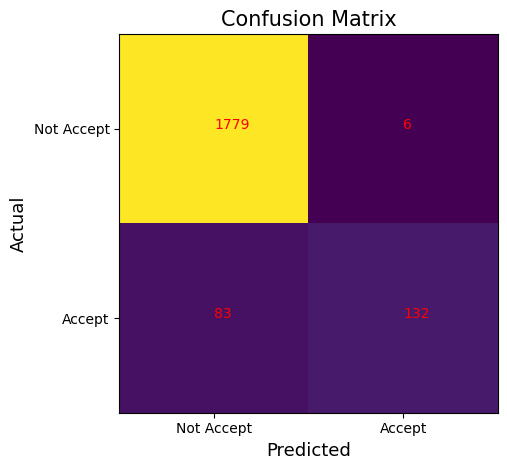

In [283]:
PlotConfusionMatrix(cm)

## Classifying Prospect Customer using best K = 3

Our knn object is already fit to use best k = 3. We did this when we wanted to calculate confusion matrix (see above). 

In [284]:
print('Prediction: ', knn.predict(prospect))

distances, indices = knn.kneighbors(prospect)
print('Distances: ', distances)
print('Indices: ', indices)
print(trainNorm.iloc[indices[0], :])

Prediction:  [1]
Distances:  [[90.53760376 90.55816785 90.59831276]]
Indices:  [[1438 2600 1546]]
           Age  Experience    Income    Family     CCAvg  Mortgage  \
662   1.709914    1.817647  2.462830  0.529738  0.049677 -0.547625   
4292  1.536362    1.470326  2.594686 -0.340587  1.370200  1.469803   
940   1.362811    1.383496  2.638638 -1.210912  1.599856  1.450121   

      Securities_Account  CD_Account    Online  CreditCard  Education_1  \
662            -0.346151   -0.248891 -1.240190   -0.645314    -0.856799   
4292           -0.346151   -0.248891 -1.240190   -0.645314    -0.856799   
940            -0.346151   -0.248891  0.806328   -0.645314    -0.856799   

      Education_2  Education_3  Personal_Loan  
662      1.587806    -0.643242              1  
4292    -0.629800     1.554624              1  
940     -0.629800     1.554624              1  


## Result

From above results we see that our prospect customer is most likely to accept the personal loan offer since our prospect customers' closest neighbors are loan accepting customers. Note that this result is different from the k-nn = 1 that we calculated first. This is because with k-nn = 1, we trained the algorithm on whole dataset, whereas with k-nn = 3, we trained the dataset on only training data. In addition, earlier we used only one neighbor and this time we used 3 neighbors. 

## Repartitioning the data

Repartitioning the data, this time into training, validation, and test sets (50%:30%:20%).

In [285]:
trainNorm, remainingNorm = train_test_split(dfNorm, test_size=0.5, random_state=26)
print(trainNorm.shape)
print(remainingNorm.shape)

(2500, 14)
(2500, 14)


In [286]:
validNorm, testNorm = train_test_split(remainingNorm, test_size=0.4, random_state=26)
print(validNorm.shape)
print(testNorm.shape)

(1500, 14)
(1000, 14)


In [287]:
train_X = trainNorm.drop('Personal_Loan', axis=1)
train_y = trainNorm['Personal_Loan']
valid_X = validNorm.drop('Personal_Loan', axis=1)
valid_y = validNorm['Personal_Loan']
test_X = testNorm.drop('Personal_Loan', axis=1)
test_y = testNorm['Personal_Loan']

## K-NN Classification (K = 3)

In [288]:
knn = KNeighborsClassifier(n_neighbors=3).fit(train_X, train_y)

Computing confusion matrix of training data

In [289]:
predicted = knn.predict(train_X)

cm = confusion_matrix(train_y, predicted)
print('Accuracy Score: ', accuracy_score(train_y, predicted))
print('Confusion Matrix')
print(cm)

Accuracy Score:  0.9764
Confusion Matrix
[[2271    5]
 [  54  170]]


In [290]:
findOutputCounts(train_y.to_numpy(), predicted)

Actual Value Counts
Total Element Count: 2500
Not Accept Count: 2276
Accept Count: 224

Predicted Value Counts
Total Element Count: 2500
Not Accept Count: 2325
Accept Count: 175


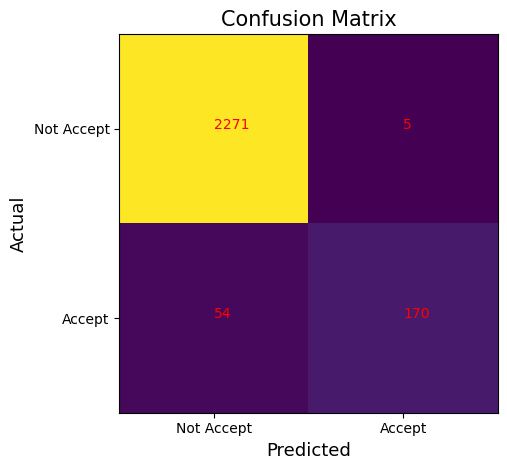

In [291]:
PlotConfusionMatrix(cm)

Computing confusion matrix of validation data

In [292]:
predicted = knn.predict(valid_X)

cm = confusion_matrix(valid_y, predicted)
print('Accuracy Score: ', accuracy_score(valid_y, predicted))
print('Confusion Matrix')
print(cm)

Accuracy Score:  0.9573333333333334
Confusion Matrix
[[1345    8]
 [  56   91]]


In [293]:
findOutputCounts(valid_y.to_numpy(), predicted)

Actual Value Counts
Total Element Count: 1500
Not Accept Count: 1353
Accept Count: 147

Predicted Value Counts
Total Element Count: 1500
Not Accept Count: 1401
Accept Count: 99


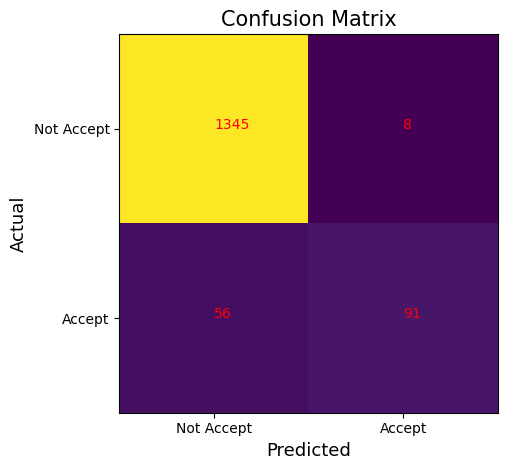

In [294]:
PlotConfusionMatrix(cm)

Computing confusion matrix of test data

In [295]:
predicted = knn.predict(test_X)

cm = confusion_matrix(test_y, predicted)
print('Accuracy Score: ', accuracy_score(test_y, predicted))
print('Confusion Matrix')
print(cm)

Accuracy Score:  0.959
Confusion Matrix
[[890   1]
 [ 40  69]]


In [296]:
findOutputCounts(test_y.to_numpy(), predicted)

Actual Value Counts
Total Element Count: 1000
Not Accept Count: 891
Accept Count: 109

Predicted Value Counts
Total Element Count: 1000
Not Accept Count: 930
Accept Count: 70


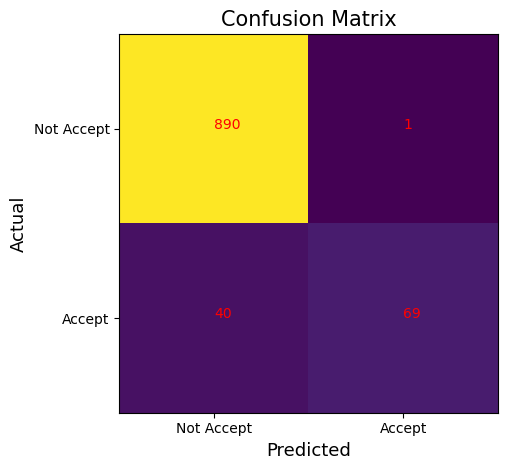

In [297]:
PlotConfusionMatrix(cm)

## Result

The diagonal elements of the confusion matrix represent the correct predictions, while the off-diagonal elements represent the errors. You want to have high values on the diagonal and low values on the off-diagonal. If we compare confusion  matrix of the test dataset with that of training and validation dataset, we see that, in the test set diagonal elements have high values and off-diagonal elements have low values compared to diagonal and non-diagonal values of confusion matrices of validation and training datasets. There is not a huge difference but values of test set are still lower than values of validation and training sets. This means our algorighm is doing well while classifying. 